In [1]:
!nvidia-smi

Fri Dec 19 04:51:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# ============================================================
# 0. Setup & Installation
# ============================================================
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.4 MB/s eta 0:00:00


In [3]:
import os
import shutil
import random
import yaml
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# ---------------- CONFIGURATION ---------------- #

BASE_DATASET = Path("/kaggle/input/bangladesh-traffic/Bangladeshi Traffic Flow Dataset/Annotated Images")
WORK_DIR     = Path("/kaggle/working/traffic_project")
SPLIT_DIR    = WORK_DIR / "dataset_split"
OUTPUT_DIR   = WORK_DIR / "outputs"
DATA_YAML    = WORK_DIR / "data.yaml"

# Folder Cleanup (TO run every time freshly)
if WORK_DIR.exists():
    shutil.rmtree(WORK_DIR)
WORK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


CLASSES = ["Rickshaw","Bus","Truck","Bike","Mini-truck","People","Car","CNG","Cycle"]


# ============================================================
# 1. Data Processing: VOC to YOLO & Splitting
# ============================================================
def voc2yolo(xml_file, classes, out_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find("size")
    w = int(size.find("width").text)
    h = int(size.find("height").text)

    with open(out_file, "w") as f:
        for obj in root.iter("object"):
            cls = obj.find("name").text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)
            xmlbox = obj.find("bndbox")
            xmin = float(xmlbox.find("xmin").text)
            ymin = float(xmlbox.find("ymin").text)
            xmax = float(xmlbox.find("xmax").text)
            ymax = float(xmlbox.find("ymax").text)
            
            # Normalize
            x_center = (xmin + xmax) / 2.0 / w
            y_center = (ymin + ymax) / 2.0 / h
            bbox_w = (xmax - xmin) / w
            bbox_h = (ymax - ymin) / h
            
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {bbox_w:.6f} {bbox_h:.6f}\n")

def prepare_dataset(base_dir, split_dir, classes, ratios=(0.7, 0.2, 0.1)):
    all_pairs = []
    # Finding all images and their XML File.
    for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG"]:
        for img_file in Path(base_dir).rglob(ext):
            xml_file = img_file.with_suffix(".xml")
            if xml_file.exists():
                all_pairs.append((img_file, xml_file))
    
    print(f"➤ Total annotated images found: {len(all_pairs)}")
    random.shuffle(all_pairs)
    
    n = len(all_pairs)
    n_train = int(n * ratios[0])
    n_val   = int(n * ratios[1])
    
    splits = {
        "train": all_pairs[:n_train],
        "val":   all_pairs[n_train:n_train+n_val],
        "test":  all_pairs[n_train+n_val:]
    }
    
    for split_name, files in splits.items():
        img_dir = split_dir / split_name / "images"
        lbl_dir = split_dir / split_name / "labels"
        img_dir.mkdir(parents=True, exist_ok=True)
        lbl_dir.mkdir(parents=True, exist_ok=True)
        
        for img_f, xml_f in files:
            shutil.copy(img_f, img_dir / img_f.name)
            voc2yolo(xml_f, classes, lbl_dir / f"{img_f.stem}.txt")
            
        print(f"  - {split_name}: {len(files)} images")

print("--- Step 1: Preparing Dataset ---")
prepare_dataset(BASE_DATASET, SPLIT_DIR, CLASSES)

# Creating YAML 
data_config = {
    "path": str(SPLIT_DIR),
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "nc": len(CLASSES),
    "names": CLASSES
}
with open(DATA_YAML, "w") as f:
    yaml.dump(data_config, f)
print("✓ Dataset ready at:", DATA_YAML)

--- Step 1: Preparing Dataset ---
➤ Total annotated images found: 23678
  - train: 16574 images
  - val: 4735 images
  - test: 2369 images
✓ Dataset ready at: /kaggle/working/traffic_project/data.yaml


In [5]:
# ============================================================
# 2. Train Base Model (Teacher)
# ============================================================
print("\n--- Step 2: Training Base Model (Teacher) ---")
base_model = YOLO("yolo12s.pt") 

base_model.train(
    data=str(DATA_YAML),
    epochs=50,            
    imgsz=640,
    batch=16,
    device='0,1',
    project=str(OUTPUT_DIR),
    name="base_run",
    verbose=True
)




--- Step 2: Training Base Model (Teacher) ---
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_project/data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, n

In [6]:
# ============================================================
# 3. Pseudo-Labeling Process
# ============================================================
print("\n--- Step 3: Generating Pseudo-Labels ---")

# Loading Best Model 
best_base_weight = OUTPUT_DIR / "/kaggle/working/traffic_project/outputs/base_run/weights/best.pt"
teacher_model = YOLO(str(best_base_weight))

# Specify unlabeled source
# (Note: For the sake of the project, we are using the 'test' set as unlabeled.
# In reality, you should provide the path to your new unlabeled folder here.

UNLABELED_SOURCE = SPLIT_DIR / "test/images" 

# Confidence threshold (important to keep high)
CONF_THRESHOLD = 0.70 

pseudo_count = 0
train_img_dir = SPLIT_DIR / "train/images"
train_lbl_dir = SPLIT_DIR / "train/labels"

# Loop over unlabeled images
unlabeled_images = list(UNLABELED_SOURCE.glob("*"))

for img_path in unlabeled_images:
    # 1. Inference
    results = teacher_model.predict(img_path, conf=CONF_THRESHOLD, verbose=False)
    
  # If high confidence object is found
    if len(results[0].boxes) > 0:
       # 2. Copy the image to the main train folder (adding pseudo_ before the file name so that it is not overwritten)
        new_img_name = f"pseudo_{img_path.name}"
        shutil.copy(img_path, train_img_dir / new_img_name)
        
      # 3. Creating label files
        label_file = train_lbl_dir / f"pseudo_{img_path.stem}.txt"
        
        with open(label_file, "w") as f:
            for box in results[0].boxes:
                cls_id = int(box.cls[0])
                x, y, w, h = box.xywhn[0].tolist() # নরমালাইজড কোঅর্ডিনেট
                f.write(f"{cls_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")
        
        pseudo_count += 1

print(f"✓ Pseudo-Labeling Complete!")
print(f"  - Original Unlabeled/Test images: {len(unlabeled_images)}")
print(f"  - High confidence images added to train: {pseudo_count}")

# ============================================================
# 4. Retrain Student Model (With Mixed Data)
# ============================================================
print("\n--- Step 4: Retraining Student Model ---")

# We can either fine-tune the previous model or start over.
# Here we are starting from the previous best weight (Fine-tuning)
student_model = YOLO(str(best_base_weight))

student_model.train(
    data=str(DATA_YAML),  # Same YAML, because we copied the new file inside the folder
    epochs=50,            # Train again
    imgsz=640,
    batch=16,
    device='0,1',
    lr0=0.005,            # Learning rate has been slightly reduced
    project=str(OUTPUT_DIR),
    name="student_pseudo_run"
)

print("\n✓ Process Completed Successfully!")
print(f"Check outputs at: {OUTPUT_DIR}")


--- Step 3: Generating Pseudo-Labels ---
✓ Pseudo-Labeling Complete!
  - Original Unlabeled/Test images: 2369
  - High confidence images added to train: 2276

--- Step 4: Retraining Student Model ---
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
                                                       CUDA:1 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/traffic_project/data.yaml, degrees=0.0, deterministic=True, device=0,1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0,


🏆 PERFORMANCE COMPARISON TABLE
              Model Type             Training Data  mAP@0.5  mAP@0.5:0.95
    Base Model (Teacher)     Original Labeled Only  0.74985       0.51691
Pseudo-Labeled (Student) Original + Pseudo Labeled  0.74731       0.51672
--------------------------------------------------
Improvement (mAP@0.5)    : -0.0025
Improvement (mAP@0.5:.95): -0.0002



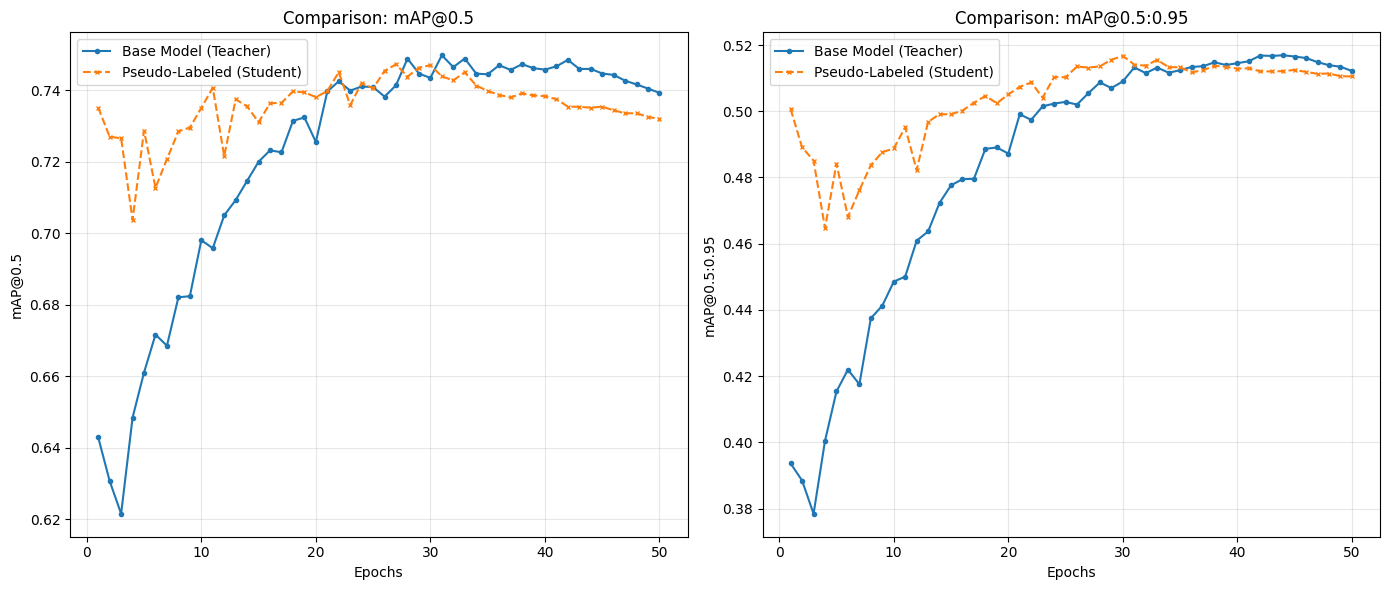

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path


WORK_DIR     = Path("/kaggle/working/traffic_project")
OUTPUT_DIR   = WORK_DIR / "outputs"


BASE_MODEL_NAME   = "base_run"            # Teacher
PSEUDO_MODEL_NAME = "student_pseudo_run"  # Student

def get_best_metrics(model_dir):
    csv_path = model_dir / "results.csv"
    
    if not csv_path.exists():
        print(f"⚠ Warning: No results found at {csv_path}")
        return None, None
    
    # Loading CSV and removing spaces
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    
  # Finding the best mAP
    best_map50 = df['metrics/mAP50(B)'].max()
    best_map50_95 = df['metrics/mAP50-95(B)'].max()
    
    return df, (best_map50, best_map50_95)

# --- Loading data ---
base_dir = OUTPUT_DIR / BASE_MODEL_NAME
pseudo_dir = OUTPUT_DIR / PSEUDO_MODEL_NAME

df_base, metrics_base = get_best_metrics(base_dir)
df_pseudo, metrics_pseudo = get_best_metrics(pseudo_dir)

# ==========================================
# PART 1: Performance Comparison Table
# ==========================================
if metrics_base and metrics_pseudo:
    data = {
        "Model Type": ["Base Model (Teacher)", "Pseudo-Labeled (Student)"],
        "Training Data": ["Original Labeled Only", "Original + Pseudo Labeled"],
        "mAP@0.5": [metrics_base[0], metrics_pseudo[0]],
        "mAP@0.5:0.95": [metrics_base[1], metrics_pseudo[1]]
    }
    
    comp_df = pd.DataFrame(data)
    
    # Improvement Calculation
    diff_map50 = metrics_pseudo[0] - metrics_base[0]
    diff_map95 = metrics_pseudo[1] - metrics_base[1]
    
    print("\n" + "="*50)
    print("🏆 PERFORMANCE COMPARISON TABLE")
    print("="*50)
    print(comp_df.to_string(index=False))
    print("-" * 50)
    print(f"Improvement (mAP@0.5)    : {diff_map50:+.4f}")
    print(f"Improvement (mAP@0.5:.95): {diff_map95:+.4f}")
    print("="*50 + "\n")

# ==========================================
# PART 2: Visualizations (mAP Curves)
# ==========================================
plt.figure(figsize=(14, 6))

# Graph 1: mAP@0.5
plt.subplot(1, 2, 1)
if df_base is not None:
    plt.plot(df_base['epoch'], df_base['metrics/mAP50(B)'], label='Base Model (Teacher)', marker='o', markersize=3)
if df_pseudo is not None:
    plt.plot(df_pseudo['epoch'], df_pseudo['metrics/mAP50(B)'], label='Pseudo-Labeled (Student)', marker='x', markersize=3, linestyle='--')

plt.title('Comparison: mAP@0.5')
plt.xlabel('Epochs')
plt.ylabel('mAP@0.5')
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 2: mAP@0.5:0.95
plt.subplot(1, 2, 2)
if df_base is not None:
    plt.plot(df_base['epoch'], df_base['metrics/mAP50-95(B)'], label='Base Model (Teacher)', marker='o', markersize=3)
if df_pseudo is not None:
    plt.plot(df_pseudo['epoch'], df_pseudo['metrics/mAP50-95(B)'], label='Pseudo-Labeled (Student)', marker='x', markersize=3, linestyle='--')

plt.title('Comparison: mAP@0.5:0.95')
plt.xlabel('Epochs')
plt.ylabel('mAP@0.5:0.95')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()